In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectPercentile, mutual_info_regression
from xgboost import XGBRegressor
from sklearn.impute import KNNImputer
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats
from statsmodels.tsa.stattools import acf
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score

import optuna
import xgboost as xgb
from sklearn.metrics import mean_absolute_error


# Import data

In [91]:
gdpnow = pd.read_csv('gdpnow_hf.csv', index_col='Dates', parse_dates=True) #date_parser=dateparse)
# Ensure that load_df index is in the same date format
gdpnow.index = pd.to_datetime(gdpnow.index)

## Let's define X and y

In [92]:
# #Target S&P
# Target = 'SPX Index '
# Drop = ['Final_GDP_Interp','Quarter being forecasted', 'Advance Estimate From BEA',
#         'Publication Date of Advance Estimate','Days until advance estimate', 'Forecast Error', 'Data releases', 'NDX Index ', 'SPX Index ']

# # Target USDJPY
# Target = 'USDJPY Curncy'
# Drop = ['Quarter being forecasted', 'Advance Estimate From BEA', 'Publication Date of Advance Estimate',
#        'Days until advance estimate', 'Forecast Error', 'Data releases', 'USDJPY Curncy']

# Target 2y Interest Rates
# Target = 'USOSFR2 Curncy'
# Drop = ['Quarter being forecasted', 'Advance Estimate From BEA', 'Publication Date of Advance Estimate',
#        'Days until advance estimate', 'Forecast Error', 'Data releases', 'USOSFR2 Curncy', 'USOSFR10 Curncy']

# # Target WTI Oil
# Target = 'CL1 Comdty'
# Drop = ['Quarter being forecasted', 'Advance Estimate From BEA', 'Publication Date of Advance Estimate',
#        'Days until advance estimate', 'Forecast Error', 'Data releases', 'CL1 Comdty']

#Target GDP
Target = 'Final_GDP_Interp'
Drop = ['GDP Nowcast', 'Final_GDP_Interp', 'Quarter being forecasted', 'Advance Estimate From BEA', 'Publication Date of Advance Estimate',
      'Days until advance estimate', 'Forecast Error', 'Data releases']

# How to deal with all the NAs ?

From here on lets try two different datasets as in how to work with the NAs:
1. ffil
2. dropping NAs

In [93]:
len(gdpnow.columns)

74

In [94]:
gdpnow_filled = gdpnow.fillna(method='ffill')
# Two variables are empty quite a lot
gdpnow_dropped = gdpnow.dropna(axis=0, thresh=len(gdpnow.columns)-2)

In [95]:
gdpnow_filled.shape, gdpnow_dropped.shape

((3551, 74), (1496, 74))

# Defining X and y

We now need the X and Y for gdpnow dropped

In [96]:
# defining X and y for all three data sets (initial, dropped and filled)


X = gdpnow_dropped.drop(columns=Drop)
y = gdpnow_dropped[Target]

assert(X.shape[0]==y.shape[0])


In [97]:
# Splitting into test and train sets
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.20)


### Optuna with Preproc

In [98]:


# # Assuming X_dropped and y_dropped are your dataset

# def objective(trial):
#     # Suggest values for the preprocessing parameters
#     n_neighbors = trial.suggest_int('n_neighbors', 1, 3)
#     percentile = trial.suggest_int('percentile', 40, 80)

#     # Create the preprocessing pipeline with suggested parameters
#     preproc = Pipeline([
#         ('imputer', KNNImputer(n_neighbors=n_neighbors)),
#         ('scaler', RobustScaler()),
#         ('feature_selection', SelectPercentile(mutual_info_regression, percentile=percentile))
#     ])

#     X_preproc_train = preproc.fit_transform(X_train, y_train)

#     # Suggest values for the model's hyperparameters
#     params = {
#         'max_depth': trial.suggest_int('max_depth', 5, 50),
#         'learning_rate': trial.suggest_float('learning_rate', 0.15, 0.25),
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1200),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
#         'gamma': trial.suggest_float('gamma', 0.0, 1.0),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#         'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
#         'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 10.0),
#     }

#     # Initialize and train the XGBoost regressor
#     model = xgb.XGBRegressor(**params)
#     model.fit(X_preproc_train, y_train)

#     # Make predictions on the processed test set
#     X_preproc_test = preproc.transform(X_test)
#     preds = model.predict(X_preproc_test)

#     # Evaluate the model using negative mean absolute error
#     neg_mae = -mean_absolute_error(y_test, preds)

#     return neg_mae  # Optimize for neg_MAE

# # Create and execute the Optuna study
# study = optuna.create_study(direction='maximize')  # We are minimizing the negative MAE
# study.optimize(objective, n_trials=500)  # Adjust n_trials based on computational budget

# # Print best trial results
# print("Best trial:")
# trial = study.best_trial
# print(f" Value (neg_MAE): {trial.value:.4f}")
# for key, value in trial.params.items():
#     print(f" {key}: {value}")


# Pipeline

In [99]:
# preproc = Pipeline([
#     ('imputer', KNNImputer(n_neighbors=5)),
#     ('scaler', RobustScaler())
# ])

# preproc_selector = Pipeline([
#     ('preprocessing', preproc),  # Include the preprocessing steps with PCA
#     ('feature_selection', SelectPercentile(
#         mutual_info_regression))
# ])

# Modeling

In [100]:
""" #Modeling with initial dataset

model = XGBRegressor(random_state=42)

param_distributions = {
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [10, 15, 20],
    'model__reg_alpha': [0, 0.1, 1.0],  # L1 regularization parameter (alpha)
    'model__reg_lambda': [0, 0.1, 1.0],
    'preprocessor__feature_selection__percentile' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]# L2 regularization parameter (lambda)

}

pipe = Pipeline([
     ('preprocessor', preproc_selector),
     ('model', model)
 ])

random_search = RandomizedSearchCV(
     pipe,
     param_distributions=param_distributions,
     n_iter=10,  # Number of parameter settings that are sampled. n_iter trades off runtime vs quality of the solution.
     scoring='neg_mean_absolute_error',  # Assuming MSE is the metric of interest; adjust as needed.
     cv=5,
     verbose=2,
     #random_state=42,
     n_jobs=-1  # Use all available cores
 )

random_search.fit(X_train, y_train)

print("Best parameters found: ", random_search.best_params_)
print("Best score found: ", random_search.best_score_) """

' #Modeling with initial dataset\n\nmodel = XGBRegressor(random_state=42)\n\nparam_distributions = {\n    \'model__n_estimators\': [100, 200, 300],\n    \'model__learning_rate\': [0.01, 0.1, 0.2],\n    \'model__max_depth\': [10, 15, 20],\n    \'model__reg_alpha\': [0, 0.1, 1.0],  # L1 regularization parameter (alpha)\n    \'model__reg_lambda\': [0, 0.1, 1.0],\n    \'preprocessor__feature_selection__percentile\' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]# L2 regularization parameter (lambda)\n\n}\n\npipe = Pipeline([\n     (\'preprocessor\', preproc_selector),\n     (\'model\', model)\n ])\n\nrandom_search = RandomizedSearchCV(\n     pipe,\n     param_distributions=param_distributions,\n     n_iter=10,  # Number of parameter settings that are sampled. n_iter trades off runtime vs quality of the solution.\n     scoring=\'neg_mean_absolute_error\',  # Assuming MSE is the metric of interest; adjust as needed.\n     cv=5,\n     verbose=2,\n     #random_state=42,\n     n_jobs=-1  # Use all 

In [101]:
# random_search.score(X_test, y_test)

# Best Parameters

In [102]:
# trial.params

# Fitting best model 

In [103]:

# Extract best parameters for preprocessing and model
# best_params = study.best_trial.params
# GDP Now Best Params
best_params = {
    'n_neighbors': 3,
    'percentile': 49,
    'max_depth': 9,
    'learning_rate': 0.2498773755675101,
    'n_estimators': 1099,
    'min_child_weight': 5,
    'gamma': 4.948772788547994e-05,
    'subsample': 0.8451156656189625,
    'colsample_bytree': 0.6148165960748299,
    'reg_alpha': 0.3365824497976371,
    'reg_lambda': 3.450245765937823
}

# S&P Best Params
# best_params =  {'n_neighbors': 2,
#  'percentile': 56,
#  'max_depth': 37,
#  'learning_rate': 0.1503521782357447,
#  'n_estimators': 832,
#  'min_child_weight': 4,
#  'gamma': 0.004268364821079059,
#  'subsample': 0.584623501752701,
#  'colsample_bytree': 0.5942338910135082,
#  'reg_alpha': 0.018602555438571623,
#  'reg_lambda': 6.760024517497121}

# Create the optimal preprocessing pipeline
preproc_optimal = Pipeline([
    ('imputer', KNNImputer(n_neighbors=best_params['n_neighbors'])),
    ('scaler', RobustScaler()),
    ('feature_selection', SelectPercentile(mutual_info_regression, percentile=best_params['percentile']))
])

# Create the model with optimal parameters
model_optimal = xgb.XGBRegressor(
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    n_estimators=best_params['n_estimators'],
    min_child_weight=best_params['min_child_weight'],
    gamma=best_params['gamma'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params['reg_lambda']
)

# # Combine into a single pipeline
# pipe_optimal = Pipeline([
#     ('preprocessing', preproc_optimal),
#     ('model', model_optimal)
# ])


In [104]:
# Combine into a single pipeline
pipe_best = Pipeline([
    ('preprocessing', preproc_optimal),
    ('model', model_optimal)
])

# Fit the optimal pipeline to the trainin
pipe_best.fit(X_train, y_train)

# Assuming X_train and y_train are already defined and contain your training data
score = cross_val_score(pipe_best, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')



# Printing the standard deviation and mean of the cross-validation scores
print(score.std())
print(score.mean())

0.04258748934810164
-0.18092710584226518


In [116]:
import csv
csv_file = 'best_params_GDP.csv'

# Define the fieldnames for the CSV file
fieldnames = ['Parameter', 'Value']

# Write the dictionary to the CSV file
with open(csv_file, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fieldnames)

    # Write the header
    writer.writeheader()

    # Write each key-value pair as a row
    for key, value in best_params.items():
        writer.writerow({'Parameter': key, 'Value': value})

print(f"CSV file '{csv_file}' has been created.")

CSV file 'best_params_GDP.csv' has been created.


## Load Best Parameters into a CSV

In [119]:
csv_file = 'best_params_GDP.csv'

# Initialize an empty dictionary to store the loaded data
loaded_params = {}

# Read the CSV file and populate the dictionary
with open(csv_file, mode='r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        param_name = row['Parameter']
        param_value = row['Value']
        loaded_params[param_name] = param_value

loaded_params

{'n_neighbors': '3',
 'percentile': '49',
 'max_depth': '9',
 'learning_rate': '0.2498773755675101',
 'n_estimators': '1099',
 'min_child_weight': '5',
 'gamma': '4.948772788547994e-05',
 'subsample': '0.8451156656189625',
 'colsample_bytree': '0.6148165960748299',
 'reg_alpha': '0.3365824497976371',
 'reg_lambda': '3.450245765937823'}

# Predictions on X_test

In [105]:
y_pred = pipe_best.predict(X_test)

In [106]:
y_pred = pd.Series(y_pred).reset_index(drop = True)

In [107]:
y_pred.index = y_test.index
df_plot = pd.DataFrame()
df_plot = pd.concat([y_test, y_pred], axis=1)


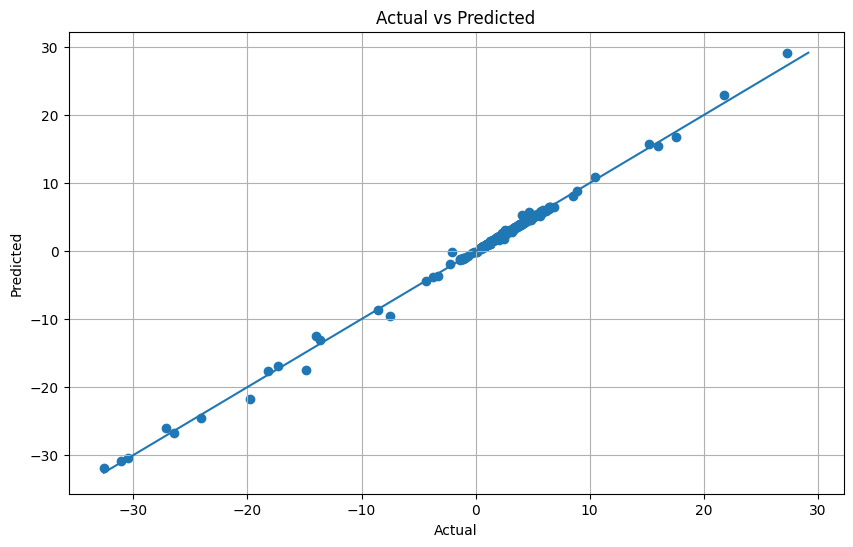

In [108]:
# Compute dynamic min and max for the line
min_val = min(df_plot[Target].min(), df_plot[0].min())
max_val = max(df_plot[Target].max(), df_plot[0].max())

# Adjust a and b dynamically
a = [min_val, max_val]
b = [min_val, max_val]

plt.figure(figsize=(10, 6))
plt.plot(a,b)
scatter = plt.scatter(df_plot[Target], df_plot[0] )
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.grid(True)
plt.show()

# Loss curves

[0]	validation_0-mae:1.92575	validation_1-mae:1.98189
[1]	validation_0-mae:1.43618	validation_1-mae:1.46633
[2]	validation_0-mae:1.08412	validation_1-mae:1.09479
[3]	validation_0-mae:0.83615	validation_1-mae:0.84299
[4]	validation_0-mae:0.63501	validation_1-mae:0.64201
[5]	validation_0-mae:0.48548	validation_1-mae:0.49760
[6]	validation_0-mae:0.37771	validation_1-mae:0.39062
[7]	validation_0-mae:0.28963	validation_1-mae:0.31594
[8]	validation_0-mae:0.22199	validation_1-mae:0.26319


/Users/javierasua/.pyenv/versions/3.10.6/envs/project-btm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[9]	validation_0-mae:0.17416	validation_1-mae:0.22924
[10]	validation_0-mae:0.13736	validation_1-mae:0.20506
[11]	validation_0-mae:0.10964	validation_1-mae:0.18839
[12]	validation_0-mae:0.08943	validation_1-mae:0.17713
[13]	validation_0-mae:0.07207	validation_1-mae:0.17044
[14]	validation_0-mae:0.06067	validation_1-mae:0.16670
[15]	validation_0-mae:0.05145	validation_1-mae:0.16444
[16]	validation_0-mae:0.04623	validation_1-mae:0.16281
[17]	validation_0-mae:0.04266	validation_1-mae:0.16234
[18]	validation_0-mae:0.03825	validation_1-mae:0.16048
[19]	validation_0-mae:0.03544	validation_1-mae:0.15957
[20]	validation_0-mae:0.03293	validation_1-mae:0.15837
[21]	validation_0-mae:0.03157	validation_1-mae:0.15808
[22]	validation_0-mae:0.02806	validation_1-mae:0.15617
[23]	validation_0-mae:0.02548	validation_1-mae:0.15460
[24]	validation_0-mae:0.02294	validation_1-mae:0.15328
[25]	validation_0-mae:0.02179	validation_1-mae:0.15279
[26]	validation_0-mae:0.02036	validation_1-mae:0.15220
[27]	valida

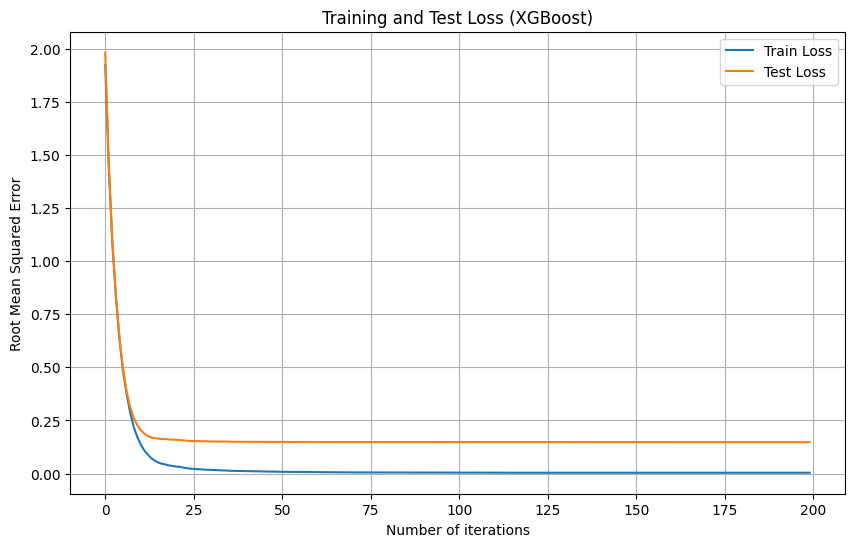

In [109]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Assuming you have your X_train, y_train, X_test, and y_test data prepared

# Define the XGBoost regressor
xgb_regressor = xgb.XGBRegressor(n_estimators=200, max_depth = 9, learning_rate = 0.275, random_state=42, reg_lambda = 0.01)

X_train_preproc = preproc_optimal.fit_transform(X_train, y_train)
X_test_preproc = preproc_optimal.transform(X_test)

# Fit the model with evaluation set
eval_set = [(X_train_preproc, y_train), (X_test_preproc, y_test)]
xgb_regressor.fit(X_train_preproc, y_train, eval_set=eval_set, eval_metric="mae", verbose=True)

# Extract training and validation loss from the model's history
results = xgb_regressor.evals_result()
train_loss = results['validation_0']['mae']
test_loss = results['validation_1']['mae']

# Plot the train and test loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Number of iterations')
plt.ylabel('Root Mean Squared Error')
plt.title('Training and Test Loss (XGBoost)')
plt.legend()
plt.grid()
plt.show()

# Predictions on Unseen data (> 19/01/2024)

In [110]:
predict_data = pd.read_csv('predict_set.csv', index_col='Dates', parse_dates=True) #date_parser=dateparse)

predict_data.index = pd.to_datetime(predict_data.index)

unseen_X = predict_data.drop(columns=Drop)
unseen_y = predict_data[Target]

assert(unseen_X.shape[0]==unseen_y.shape[0])

In [111]:
predictions = pipe_best.predict(unseen_X)
gdpnow_nowcast = predict_data['GDP Nowcast']
predictions = pd.Series(predictions)
predictions.index = unseen_y.index
df_plot = pd.DataFrame()
df_plot = pd.concat([gdpnow_nowcast, predictions], axis=1)
df_plot = df_plot.loc['2024-01-19':]
df_plot

,GDP Nowcast,0
Dates,,
2024-01-19,2.4,3.322135
2024-01-20,3.0,3.495887
2024-01-21,3.0,3.495887
2024-01-22,3.0,3.495887
2024-01-23,3.0,3.495887
...,...,...
2024-03-17,2.0,3.667692
2024-03-18,2.0,3.667692
2024-03-19,2.1,3.667692


In [112]:
from sklearn.metrics import mean_absolute_error

# Assuming you have y_test and y_pred
mae = mean_absolute_error(unseen_y, predictions)
df_plot

,GDP Nowcast,0
Dates,,
2024-01-19,2.4,3.322135
2024-01-20,3.0,3.495887
2024-01-21,3.0,3.495887
2024-01-22,3.0,3.495887
2024-01-23,3.0,3.495887
...,...,...
2024-03-17,2.0,3.667692
2024-03-18,2.0,3.667692
2024-03-19,2.1,3.667692


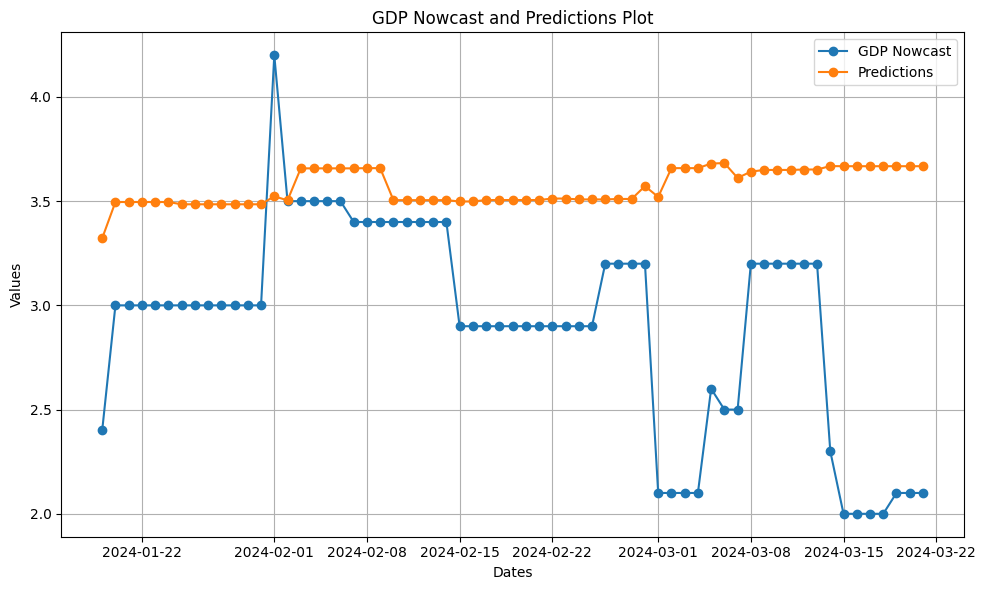

In [113]:

plt.figure(figsize=(10, 6))
plt.plot(df_plot.index, df_plot['GDP Nowcast'], marker='o', label='GDP Nowcast')
plt.plot(df_plot.index, df_plot[0], marker='o', label='Predictions')
plt.xlabel('Dates')
plt.ylabel('Values')
plt.title('GDP Nowcast and Predictions Plot')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Shapley Feature Test

In [114]:
# Feature Selection
import shap
# Compute SHAP values
# # Initialize the explainer on the entire pipeline
explainer = shap.Explainer(pipe_best.predict, X_test)
# Compute SHAP values
shap_values = explainer(X_test)
# # Visualize the feature importance
# shap.plots.bar(shap_values)
# Plot SHAP values to understand feature importance
# shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.plots.beeswarm(shap_values)
#change

PermutationExplainer explainer:  34%|███▎      | 101/300 [02:08<04:35,  1.39s/it]


KeyboardInterrupt: 

PermutationExplainer explainer: 301it [09:04,  1.85s/it]                         


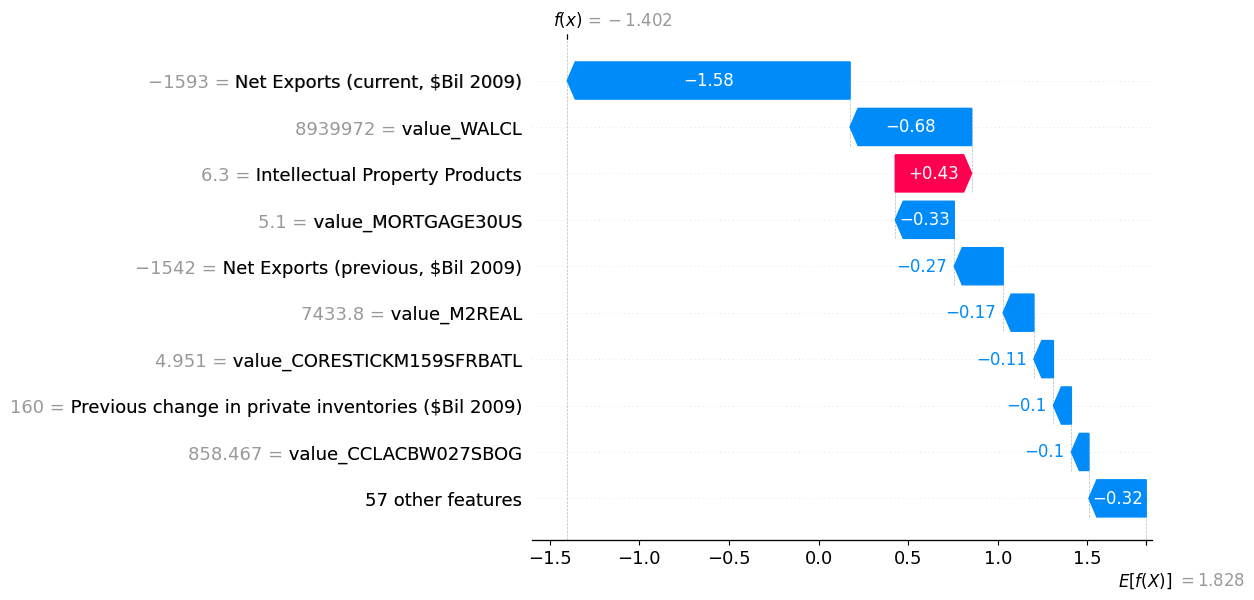

In [ ]:
# Feature Selection
import shap

# Compute SHAP values
# # Initialize the explainer on the entire pipeline
explainer = shap.Explainer(pipe_best.predict, X_test)
# Compute SHAP values
shap_values = explainer(X_test)

# # Visualize the feature importance
# shap.plots.bar(shap_values)
# Plot SHAP values to understand feature importance
# shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.plots.waterfall(shap_values[0])
#change